In [956]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from tqdm.auto import tqdm
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

In [75]:
mnist = fetch_openml("mnist_784", as_frame=False)
X, y = mnist["data"], mnist["target"]

C:\Users\Ahmed Dawoud\AppData\Roaming\Python\Python311\site-packages\sklearn\datasets\_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


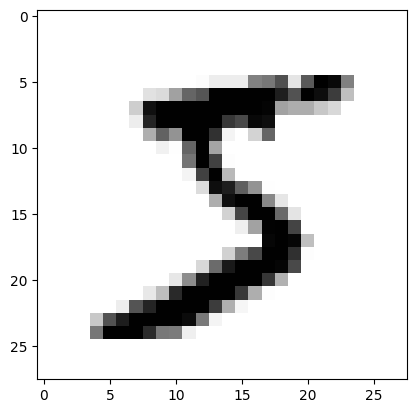

In [76]:
plt.imshow(X[0].reshape(28, 28), cmap="binary")

In [19]:
X[0].shape

(784,)

In [77]:
np.random.seed(42)
shuffle_index = np.random.permutation(70000)
X, y = X[shuffle_index], y[shuffle_index]

In [78]:
y = y.astype(np.uint8)
y_one_hot = np.zeros((len(y), 10))
for i in range(len(y)):
    y_one_hot[i][y[i]] = 1

y_one_hot[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])

In [861]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y_one_hot[:60000], y_one_hot[60000:]

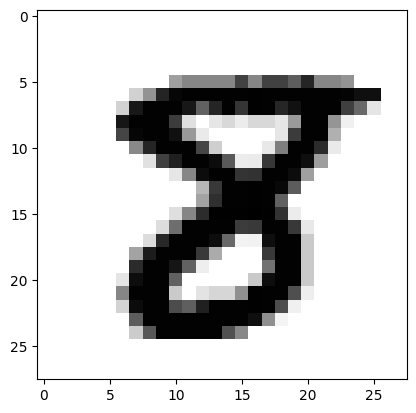

In [323]:
plt.imshow(X_train[0].reshape(28, 28), cmap="binary")

In [35]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

In [42]:
baseline_accuracy = np.sum(y_train, axis=0)[np.argmax(np.sum(y_train, axis=0))] / len(y_train)
f"{baseline_accuracy:.2%}"

'11.24%'

neural network schematic<br>
input: 784<br>
hidden layer 1: 36 -> segmoid<br>
hidden layer 2: 16 -> segmoid<br>
output: 10 -> segmoid<br>


In [813]:
w1 = np.random.randn(784, 36)
b1 = np.random.randn(36)

w2 = np.random.randn(36, 80)
b2 = np.random.randn(80)

w3 = np.random.randn(80, 10)
b3 = np.random.randn(10)

params = {"w1": w1, "b1": b1, "w2": w2, "b2": b2, "w3": w3, "b3": b3}

In [773]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_prime(x):
    return sigmoid(x) * (1 - sigmoid(x))

In [755]:
def forward(X, params):
    z1 = np.dot(X, params["w1"]) + params["b1"]
    a1 = sigmoid(z1)

    z2 = np.dot(a1, params["w2"]) + params["b2"]
    a2 = sigmoid(z2)

    z3 = np.dot(a2, params["w3"]) + params["b3"]
    a3 = sigmoid(z3)

    return {"z1": z1, "a1": a1, "z2": z2, "a2": a2, "z3": z3, "a3": a3}

In [731]:
forward(X_train, params)['a3'].shape

(60000, 10)

In [752]:
forward(X_train[0], params)['a3']

array([4.74123122e-09, 1.65531206e-08, 9.99999992e-01, 9.99130077e-01,
       3.12591186e-05, 9.99820412e-01, 2.63117822e-03, 1.00000000e+00,
       1.00000000e+00, 8.13914154e-12])

In [753]:
def loss(X, y, params):
    predictions = forward(X, params)["a3"]
    return 1 / 2 * np.sum((predictions - y) ** 2)


loss(X_train, y_train, params)

143254.34185629568

In [936]:
def backward(X, y, params):
    m = X.shape[0]
    grads = {}

    output = forward(X, params)

    da3 = output["a3"] - y
    dz3 = da3 * sigmoid_prime(output["z3"])
    grads["w3"] = np.dot(output["a2"].T, dz3) / m
    grads["b3"] = np.sum(dz3, axis=0) / m

    da2 = np.dot(dz3, params["w3"].T)
    dz2 = da2 * sigmoid_prime(output["z2"])
    grads["w2"] = np.dot(output["a1"].T, dz2) / m
    grads["b2"] = np.sum(dz2, axis=0) / m

    da1 = np.dot(dz2, params["w2"].T)
    dz1 = da1 * sigmoid_prime(output["z1"])
    grads["w1"] = np.dot(X.T, dz1) / m
    grads["b1"] = np.sum(dz1, axis=0) / m

    return grads


backward(X_train, y_train, params)["w1"].shape

(784, 36)

In [827]:
def predict(X, params):
    return np.argmax(forward(X, params)["a3"], axis=1)

In [937]:
def predict_proba(X, params):
    return forward(X, params)["a3"]

In [777]:
def update(params, grads, learning_rate):
    params["w1"] = params["w1"] - learning_rate * grads["w1"]
    params["b1"] = params["b1"] - learning_rate * grads["b1"]

    params["w2"] = params["w2"] - learning_rate * grads["w2"]
    params["b2"] = params["b2"] - learning_rate * grads["b2"]

    params["w3"] = params["w3"] - learning_rate * grads["w3"]
    params["b3"] = params["b3"] - learning_rate * grads["b3"]

    return params

In [738]:
def calc_accuracy(X, y, params):
    return np.sum(predict(X, params) == np.argmax(y, axis=1)) / len(y)

In [783]:
def save_w1(w1, name):
    fig, ax = plt.subplots(6, 6, figsize=(10, 10))
    for i, w in enumerate(w1.T):
        ax[i // 6][i % 6].imshow(w.reshape(28, 28), cmap="binary")
        ax[i // 6][i % 6].axis("off")
        ax[i // 6][i % 6].set_title(i)
    plt.savefig(f"weights/{name}.png")
    plt.close(fig)

In [814]:
def train(X, y, params, learning_rate, epochs, dec_lr=False):
    losses = []
    accuracies = []
    batch_size = 16
    lrt = learning_rate
    plt.ioff()
    for epoch in tqdm(
        range(epochs), total=epochs, desc="Epochs", unit="epoch", position=0, leave=True
    ):
        lrt = (learning_rate * 0.1) ** (epoch // 10) if dec_lr else learning_rate
        for i in range(0, len(X), batch_size):
            X_batch = X_train[i : i + batch_size]
            y_batch = y_train[i : i + batch_size]


            grads = backward(X_batch, y_batch, params)
            params = update(params, grads, lrt)

            losses.append(loss(X_batch, y_batch, params))
            accuracies.append(calc_accuracy(X_batch, y_batch, params))

        save_w1(params["w1"], f"epoch_{epoch}")

        tqdm.write(
            f"Epoch: {epoch}, Loss: {losses[-1]:.2f}, Accuracy: {accuracies[-1]:.2f}"
        )
    plt.ion()
    plt.close()

    return losses, accuracies, params

In [815]:
losses = []
accuracies = []

In [928]:
new_losses, new_accuracy, params = train(X_train, y_train, params, 0.05, 3)
losses.extend(new_losses)
accuracies.extend(new_accuracy)

Epochs:  33%|███▎      | 1/3 [00:08<00:16,  8.01s/epoch]

Epoch: 0, Loss: 0.72, Accuracy: 0.94


Epochs:  67%|██████▋   | 2/3 [00:14<00:07,  7.26s/epoch]

Epoch: 1, Loss: 0.46, Accuracy: 0.94


Epochs: 100%|██████████| 3/3 [00:21<00:00,  7.17s/epoch]

Epoch: 2, Loss: 0.50, Accuracy: 0.94


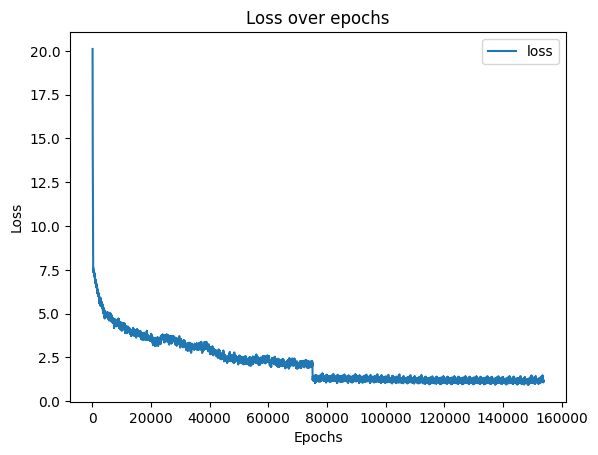

In [941]:
plt.plot(pd.Series(losses).rolling(100).mean(), label="loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over epochs")
plt.show();

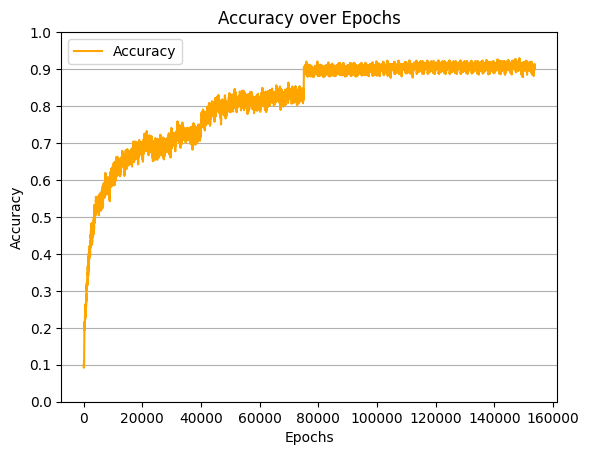

In [942]:
plt.plot(
    pd.Series(accuracies).rolling(100).mean(),
    color="orange",
    label="Accuracy",
)
plt.grid(axis="y")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylim(0, 1)
plt.show();

prediction=7
actual=7


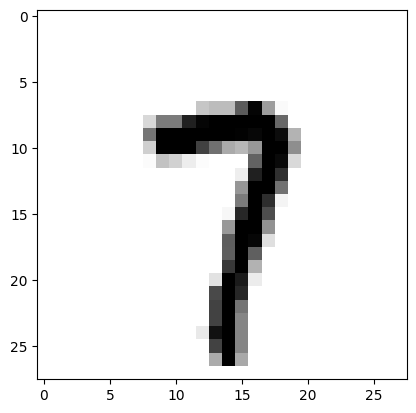

In [944]:
random_index = np.random.randint(0, len(X_test))
prediction = np.argmax(forward(X_test[random_index], params)["a3"])
actual = np.argmax(y_test[random_index])
print(f"{prediction=}\n{actual=}")
plt.imshow(X_test[random_index].reshape(28, 28), cmap="binary");

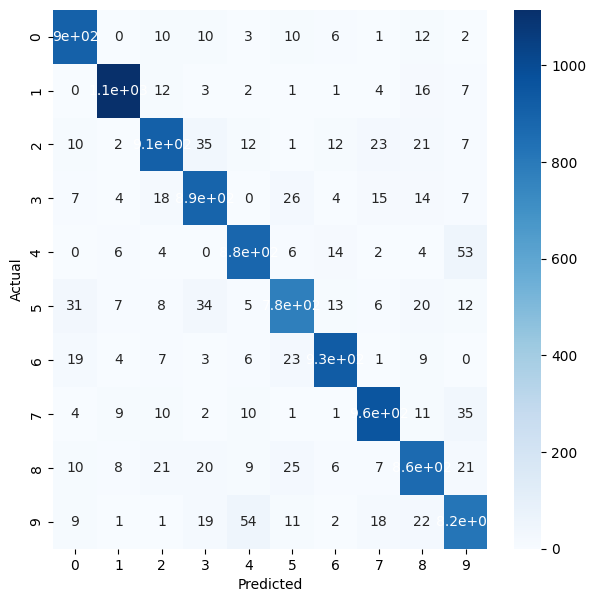

In [945]:
y_pred = predict(X_test, params)
confusion_matrix = np.zeros((10, 10))
y_test_labels = np.argmax(y_test, axis=1)
for i in range(len(y_test_labels)):
    confusion_matrix[y_test_labels[i]][y_pred[i]] += 1

plt.figure(figsize=(7, 7))
sns.heatmap(confusion_matrix, annot=True, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual");

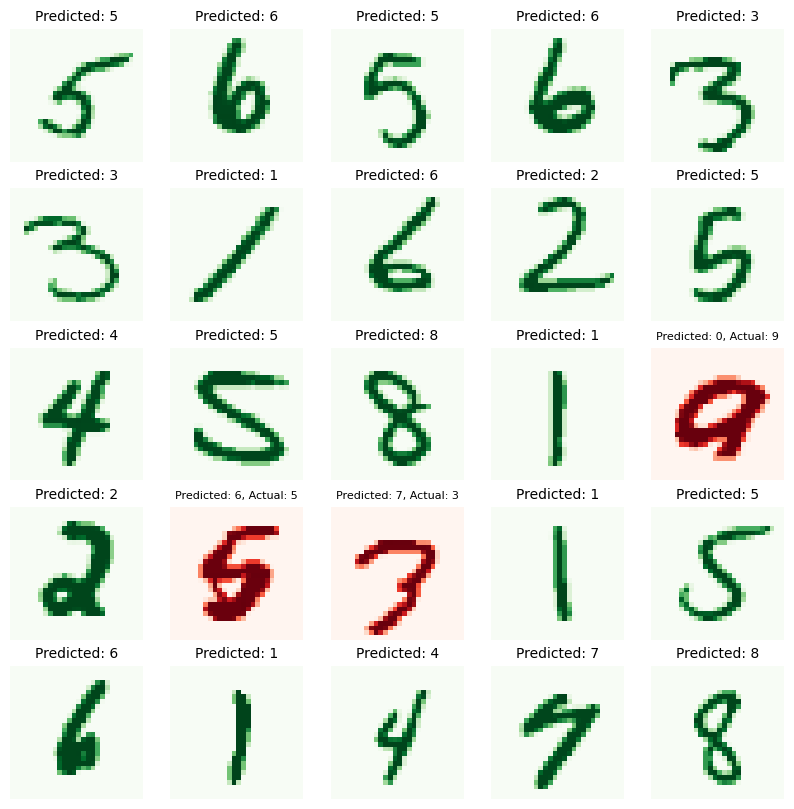

In [952]:
fig, ax = plt.subplots(5, 5, figsize=(10, 10))

for i in range(5):
    for j in range(5):
        ax[i][j].axis("off")
        random_index = np.random.randint(0, len(X_test))

        prediction = np.argmax(forward(X_test[random_index], params)["a3"])

        actual = np.argmax(y_test[random_index])

        if prediction != actual:
            ax[i][j].imshow(X_test[random_index].reshape(28, 28), cmap="Reds")
            ax[i][j].set_title(f"Predicted: {prediction}, Actual: {actual}", fontsize=8)
        else:
            ax[i][j].imshow(X_test[random_index].reshape(28, 28), cmap="Greens")
            ax[i][j].axis("off")
            ax[i][j].set_title(f"Predicted: {prediction}", fontsize=10)

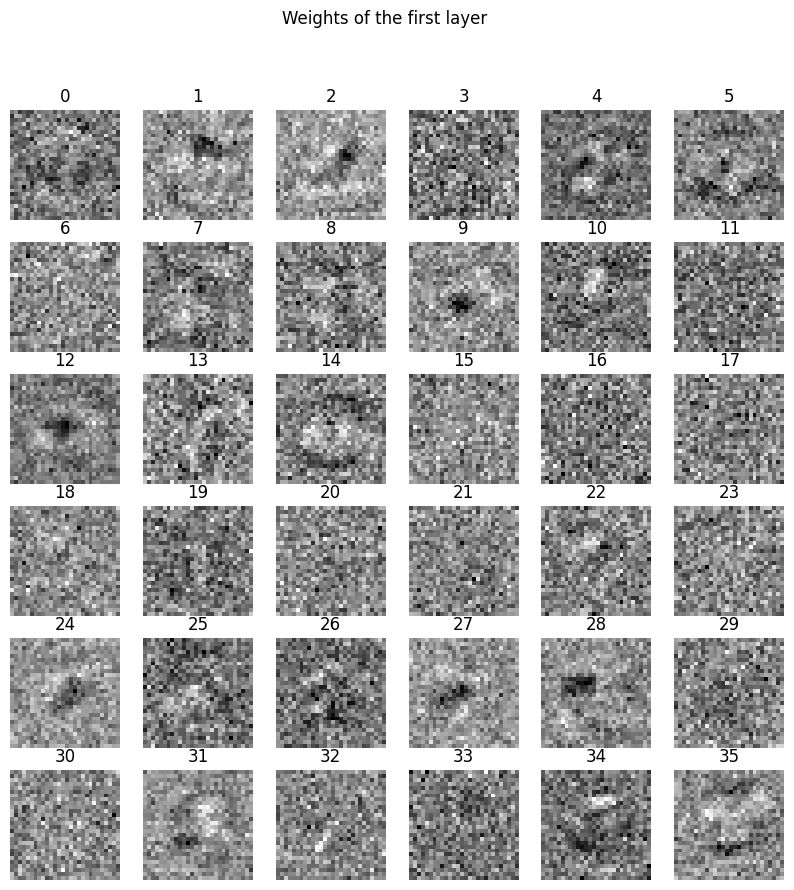

In [947]:
fig, ax = plt.subplots(6, 6, figsize=(10, 10))
for i, w in enumerate(params["w1"].T):
    ax[i//6][i%6].imshow(w.reshape(28, 28), cmap="binary")
    ax[i//6][i%6].axis("off")
    ax[i//6][i%6].set_title(i)
plt.suptitle("Weights of the first layer");

In [953]:
train_accuracy = calc_accuracy(X_train, y_train, params)
test_accuracy = calc_accuracy(X_test, y_test, params)
f"{train_accuracy:.2%}, {test_accuracy:.2%}"

'90.31%, 90.38%'

In [935]:
import pickle as pkl

with open("params.pkl", "wb") as f:
    pkl.dump(params, f)